In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 129kB/s 
     |████████████████████████████████| 3.0MB 26.6MB/s 
     |████████████████████████████████| 419kB 31.2MB/s 
     |████████████████████████████████| 61kB 16.7MB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import tensorflow as tf # ml framework
# tf.enable_eager_execution()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, glob # for managing file directories
import gzip, pickle # compression library and object serialization/deserialization library
from scipy import linalg # linear algebra functions
import pathlib # filesystem library
import urllib # library for working with urls
import warnings
from tqdm import tqdm # fast and extensible progress bar
from PIL import Image # image processing library
import pathlib # library for working with filepaths
import IPython.display as display # for inspecting the images
import random
import matplotlib.pyplot as plt # plotting library
import time

**Get image filepaths**

In [5]:
'used code from --zhangxin for get the image filepaths'
path = '../input/all-dogs'
dataset = 'all-dogs'
data_path = os.path.join(path, dataset)
all_image_paths = glob.glob(os.path.join(data_path, '*.*')) 

**Have a look at the pictures and their format**

There are 20579 dog images in the dog-images folder


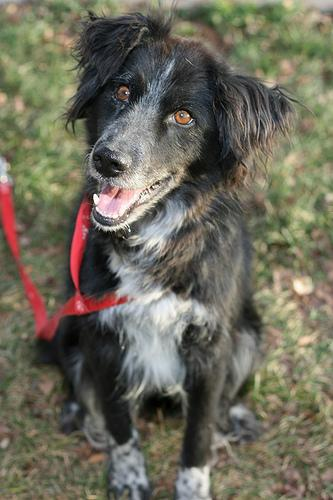

../input/all-dogs/all-dogs/n02106166_2072.jpg
(500, 333, 3) <dtype: 'uint8'>
Shape after resize (28, 28, 3)
Min rgb value after normalizing 0.0
Max rgb value after normalizing 0.9913865923881531


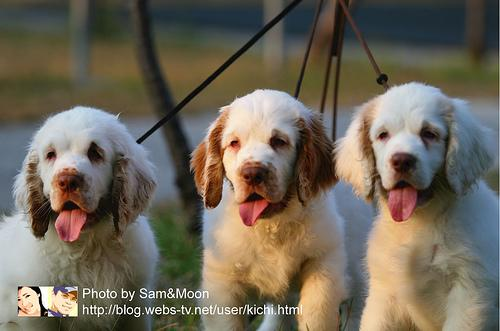

../input/all-dogs/all-dogs/n02101556_4112.jpg
(331, 500, 3) <dtype: 'uint8'>
Shape after resize (28, 28, 3)
Min rgb value after normalizing 0.0
Max rgb value after normalizing 0.9962885975837708


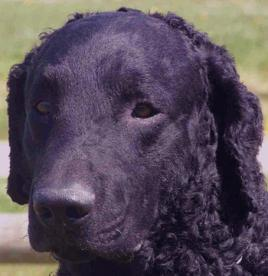

../input/all-dogs/all-dogs/n02099429_3193.jpg
(276, 268, 3) <dtype: 'uint8'>
Shape after resize (28, 28, 3)
Min rgb value after normalizing 0.02577050030231476
Max rgb value after normalizing 0.8666666746139526


In [6]:
# have a look at 3 random dog pictures from all-dogs

print('There are {} dog images in the dog-images folder'.format(len(all_image_paths)))

def image_info(path): 
    img_raw = tf.io.read_file(path)
    img_tensor = tf.image.decode_image(img_raw)
    return img_tensor
    
for n in range(3):
    image_path = random.choice(all_image_paths)
    img_tensor = image_info(image_path)
    display.display(display.Image(image_path))
    print(image_path)
    print(img_tensor.shape, img_tensor.dtype)
    img_final = tf.image.resize(img_tensor, [28, 28])
    img_final = img_final/255.0
    print('Shape after resize {}'.format(img_final.shape))
    print('Min rgb value after normalizing {}'.format(img_final.numpy().min()))
    print('Max rgb value after normalizing {}'.format(img_final.numpy().max()))
    
# 0 if black exists in the image and 1 if white exists in the image



Make dataset and format Images

In [7]:
'''Make the resizing image step previously done 
    into a function to apply to every image'''

dim = 56
# preprocessing function
def preprocess(img):
    # tf function to decode a rgb colored jpeg image
    image = tf.image.decode_jpeg(img, channels=3)
    # resize image to 56 x 56
    image = tf.image.resize(image, [dim,dim])
    # normalize the rgb values to [0,1] range
    image /= 255.0
    return image

def load_and_preprocess(path):
    image = tf.io.read_file(path)
    image = preprocess(image)
    image = np.array(image)
    image = image.reshape((56,56,3))
    return image
    
# will delegate the decision about what level of parallelism to use to the tf.data runtime
AUTOTUNE = tf.data.experimental.AUTOTUNE

# makes a dataset of the image pathnames
# path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

# image_ds = path_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

def makeMasterArray():
    masterLst=[load_and_preprocess(x) for x in all_image_paths]
    return np.array(masterLst)


In [8]:
images = makeMasterArray()
# images = [x.reshape((1,56,56,3)) for x in images]

In [9]:
print('type: {}, shape: {}'.format(type(images), images.shape))

type: <class 'numpy.ndarray'>, shape: (20579, 56, 56, 3)


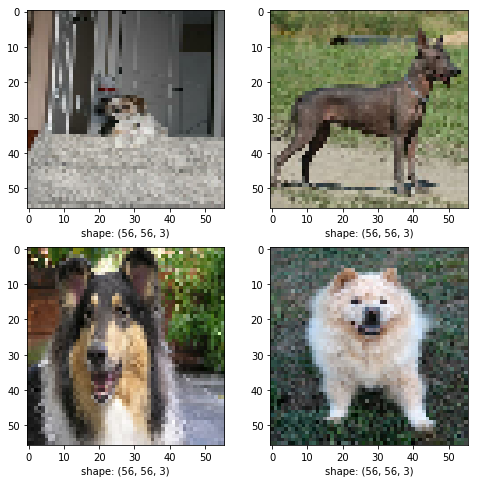

In [10]:
# view some images in the image_ds
plt.figure(figsize=(8,8))
for image in range(4):
    plt.subplot(2,2, image+1)
    plt.imshow(images[image])
    plt.xlabel('shape: {}'.format(images[image].shape))


**Reshape the data and make batches**

In [11]:
BUFFER_SIZE = 20579
BATCH_SIZE = 32

ds = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# prefetch enables the dataset to fetch batches in the background while the model trains
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

<PrefetchDataset shapes: (None, 56, 56, 3), types: tf.float32>


**Generator Model**

Text(0.5, 0, 'shape: (1, 56, 56, 3)')

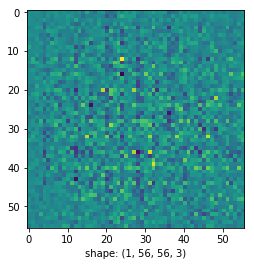

In [12]:
def make_generator():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Reshape((7, 7, 256)),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(4,4), padding='same', use_bias=False, activation='tanh'),
        ]
    )
    return model

generator = make_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.xlabel('shape: {}'.format(generated_image.shape))

**Discriminator model**

In [13]:
def make_discriminator():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[dim,dim,3]),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

print(generated_image.shape)


discriminator = make_discriminator()
decision = discriminator(generated_image)
print (decision)
    

(1, 56, 56, 3)
tf.Tensor([[0.5000192]], shape=(1, 1), dtype=float32)


**Loss and optimizers**

In [14]:
# This method returns a helper function to compute cross entropy loss
# code from tf dcgan tutorial
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# The Discriminator loss function

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator loss function

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers -- Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**Training loop**

In [15]:
# code from tf dcgan tutorial
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# code from tf dcgan tutorial
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

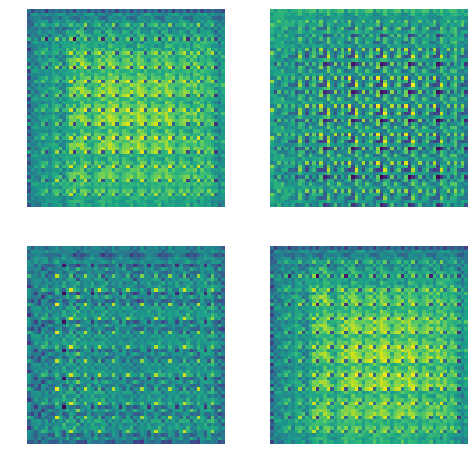

In [19]:
print('Starting training')
train(ds, EPOCHS)